In [26]:
library(limma)
library(ggplot2)
library(readxl)
library(viridis)

In [27]:
# Cargar la matriz de expresión
expr_file <- "/home/mlopez/Desktop/alzheimer/data/GSE33000/GSE33000_raw_data.txt.gz"
raw_data <- read.delim(gzfile(expr_file), comment.char = "!", header = TRUE, row.names = 1)
raw_data$ID <- rownames(raw_data)

In [28]:
# Cargar los metadata
metadata <- read.csv("/home/mlopez/Desktop/alzheimer/results/GSE33000/GSE33000_metadata.csv", stringsAsFactors = FALSE)
metadata_az_ctrol <- unique(metadata[metadata$disease.status %in% c('Alzheimer\'s disease','non-demented'),])
metadata_az_ctrol$group <- rep("-", length(metadata_az_ctrol$disease.status)) 
metadata_az_ctrol$group[metadata_az_ctrol$disease.status == "non-demented"] <- "Ctrol"
metadata_az_ctrol$group[metadata_az_ctrol$disease.status == "Alzheimer\'s disease"] <- "AD"

In [29]:
raw_data_az_ctrol <- raw_data[,colnames(raw_data) %in% metadata_az_ctrol$Source]
raw_data_az_ctrol$Gene <- raw_data$Gene
raw_data_az_ctrol$Transcript <- raw_data$Transcript
raw_data_az_ctrol$ID <- raw_data$ID

In [30]:
# Cargar el fichero de anotacion del tipo de microarray 

mapping_data <- read.csv("/home/mlopez/Desktop/alzheimer/data/GSE33000/annotation_rosetta_microarray.csv", comment.char = "#", header = TRUE, sep="\t")

In [31]:
# preparar la matrix de expresión

raw_data_annot <- merge(raw_data_az_ctrol, mapping_data, by ="ID")

#hay sonda duplicadas. me quedo con las de mayor varianza. 
exprs_data <- raw_data_annot[raw_data_annot$ORF != "",]


# 1. Calcular la varianza por fila
exprs_data$variance <- apply(exprs_data[,metadata_az_ctrol$Source], 1, var)

# 2. Ordenar por ORF y por varianza (de mayor a menor)
exprs_data_sorted <- exprs_data[order(exprs_data$ORF, -exprs_data$variance), ]

# 3. Filtrar para quedarte solo con el ORF de mayor varianza (el primero que aparece)
exprs_data_unique <- exprs_data_sorted[!duplicated(exprs_data_sorted$ORF), ]
exprs_data_alz_ctrol <- exprs_data_unique[,metadata_az_ctrol$Source]

# 4. Asignar los nombres de fila con ORF (ya no habrá duplicados)
rownames(exprs_data_alz_ctrol) <- exprs_data_unique$ORF
exprs_data_alz_ctrol$ORF <- NULL
exprs_data_alz_ctrol$ID <- NULL

In [7]:
pdf("/home/mlopez/Desktop/alzheimer/results/GSE33000/boxplot_raw_expr_GSE33000.pdf", width=20, height=12)
# Boxplot más amplio
par(mar=c(15,4,4,2))  # margenes inferiores más grandes para etiquetas
boxplot(exprs_data_alz_ctrol, las = 2, main = "Datos sin normalizar", ylab = "Expresión", col = "lightblue", outline = FALSE)
dev.off()

pdf 
  2

In [32]:
norm_expr <- normalizeBetweenArrays(exprs_data_alz_ctrol , method = "quantile")

In [9]:
pdf("/home/mlopez/Desktop/alzheimer/results/GSE33000/boxplot_norm_expr_GSE33000.pdf", width=20, height=12)
# Boxplot más amplio
par(mar=c(15,4,4,2))  # margenes inferiores más grandes para etiquetas
boxplot(norm_expr, las = 2, main = "Datos normalizados", ylab = "Expresión", col = "lightgreen", outline = FALSE)
dev.off()

pdf 
  2

In [33]:
norm_expr_clean <- norm_expr[complete.cases(norm_expr), ]  # Elimina filas con NA

In [34]:
# Transponer para que las filas sean muestras
pca <- prcomp(t(norm_expr_clean), scale. = TRUE)

pca_df <- as.data.frame(pca$x[, 1:2])  # Primeras 2 PCs
pca_df$SampleID <- rownames(pca_df)
pca_df <- merge(pca_df, metadata_az_ctrol, by.x = "SampleID", by.y="Source")

In [12]:
pdf("/home/mlopez/Desktop/alzheimer/results/GSE33000/pca_norm_expr_GSE33000.pdf")
ggplot(pca_df, aes(x = PC1, y = PC2, color = group)) +
  geom_point(size = 3, alpha = 0.8) +
  theme_minimal() +
  labs(title = "PCA of Expression Data",
       subtitle = "Colored by AD/Control, shaped by Brain Region",
       x = paste0("PC1 (", round(summary(pca)$importance[2,1] * 100, 1), "%)"),
       y = paste0("PC2 (", round(summary(pca)$importance[2,2] * 100, 1), "%)")) +
  theme(axis.text = element_text(size=10),
        plot.title = element_text(face="bold", size=14),
        legend.title = element_text(size=12))
dev.off()

pdf 
  2

In [35]:
design <- model.matrix(~0 + factor(metadata_az_ctrol$group))  # 0 indica sin intercepto
colnames(design) <- c("AD", "Ctrol")  # Asigna nombres de columna a los grupos


fit <- lmFit(norm_expr_clean, design)  # Ajuste del modelo para los datos

contrast.matrix <- makeContrasts(AD - Ctrol, levels = design)
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

results <- topTable(fit2, adjust = "fdr", sort.by = "P", number = Inf)  # Ajuste FDR y ordenación por P-valor

In [36]:
write.csv(results, file = "/home/mlopez/Desktop/alzheimer/results/GSE28146/dif_expr_results_GSE28146.csv", row.names = TRUE)

In [39]:
AD_T4_targets <- read_excel("/home/mlopez/Desktop/alzheimer/data/AD_T4_targets.xlsx")

New names:
• `` -> `...1`


In [40]:
T4_exp_dif <- na.omit(results[AD_T4_targets$Prot,])

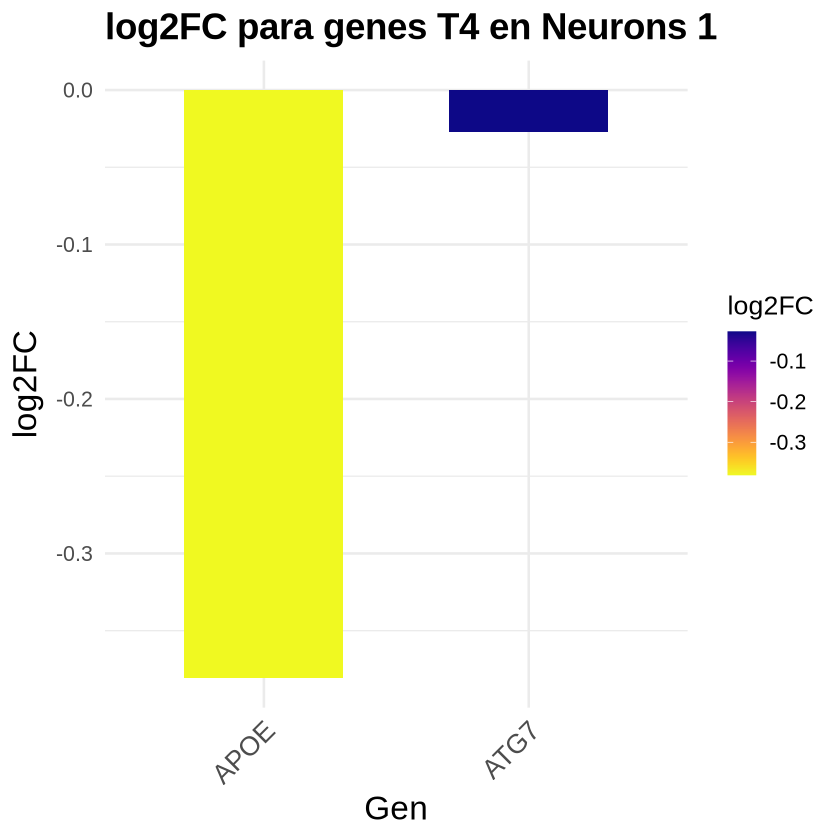

In [44]:
T4_exp_dif_sig <- T4_exp_dif[T4_exp_dif$adj.P.Val < 0.05, ]

T4_exp_dif_sig$gene <- rownames(T4_exp_dif_sig)

ggplot(T4_exp_dif_sig, aes(x = gene, y = logFC, fill = logFC)) +
  geom_col(width = 0.6) +
  scale_fill_viridis(option = "C", direction = -1) +
  labs(
    title = "log2FC para genes T4 en Neurons 1",
    x = "Gen",
    y = "log2FC",
    fill = "log2FC"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
    axis.title = element_text(size = 20),
    plot.title = element_text(size = 22, face = "bold")
  )